In [48]:
%run IDM_helper_functions.ipynb

In [7]:
from pyddm import Model
from pyddm.models import DriftConstant, DriftLinear, NoiseConstant, Bound, Drift, BoundConstant, OverlayNonDecision, ICPointSourceCenter
from pyddm.functions import fit_adjust_model, display_model

from pyddm import Fittable, Fitted, Sample
from pyddm.models import LossRobustBIC, LossBIC, LossLikelihood, LossRobustLikelihood,LossSquaredError
from pyddm.functions import fit_adjust_model

In [32]:
import pandas as pd
import os
import scipy.io as sio
import scipy
from statsmodels.stats.anova import AnovaRM
import seaborn as sns
import numpy as np

In [13]:
from sbi import utils

In [9]:
class BoundSpeedAcc(Bound):
    name = "constant"
    required_parameters = ["Bspeed", "Bacc"]
    required_conditions = ['SAT']
    def get_bound(self, conditions, *args, **kwargs):
        assert self.Bacc > 0
        assert self.Bspeed > 0
        if conditions['SAT'] == 1:
            return self.Bspeed
        else:
            return self.Bacc

class DriftSpeedAcc(Drift):
    name = "DriftLinearSAT"
    required_parameters = ["drift", "Kspeed", "Kacc"]
    required_conditions = ['SAT']
        
    def get_drift(self, x, t, conditions, **kwargs):
        if conditions['SAT'] == 1:
            return self.drift + x*self.Kspeed 
        else:
            return self.drift + x*self.Kacc

## Simulate with DDM with two boundary parameters
## Fit with OUM allowing both boundary and inhibition to vary

In [107]:
##                              v  a1 a2  k1 k2 ter 
#prior = utils.BoxUniform(low  =[0,0.5,0.5, 0,0, 0.2], 
#                         high =[3,  2,  2,8,8,0.5])

##                              v  a1 a2  ter 
prior = utils.BoxUniform(low  =[0,0.5,0.5,0.2], 
                         high =[3,  2,  2,0.5])

n_sim = 30
param = np.array(prior.sample((n_sim,)))


In [108]:
param_DDM_df = pd.DataFrame(param, columns = ['v', 'a1', 'a2', 'ter'])
param_DDM_df.to_csv("DDM-OUM-SAT-simulation")

In [109]:
df_all = pd.DataFrame(columns = ['v','a1','a2', 'k1', 'k2', 'ter'])

for i in range(n_sim):
    print(i)
    model = Model(name='Simple model (fitted)',
                  drift=DriftConstant(drift = param[i,0]),
                  noise=NoiseConstant(noise =1),
                  bound=BoundSpeedAcc(Bspeed = param[i,1],Bacc = param[i,2]),
                  overlay=OverlayNonDecision(nondectime=param[i,3]),
                  dx=.001, dt=.001, T_dur=3)

    samp1 = model.solve({"SAT": 1}).resample(1000)
    samp2 = model.solve({"SAT": 2}).resample(1000)
    df = samp1.to_pandas_dataframe(drop_undecided = "True").append(samp2.to_pandas_dataframe(drop_undecided = "True"))
    DDM_sample = Sample.from_pandas_dataframe(df, rt_column_name="RT", correct_column_name="correct")

    model_fit = Model(name='Simple model (fitted)',
                  drift=DriftSpeedAcc(drift = Fittable(minval=0, maxval=4),
                                      Kspeed=Fittable(minval=-5, maxval=10),
                                      Kacc=Fittable(minval=-5, maxval=10)),

                  noise=NoiseConstant(noise=1),
                  bound=BoundSpeedAcc(
                      Bspeed=Fittable(minval=.3, maxval=3),
                      Bacc=Fittable(minval=.3, maxval=3)),
                  overlay=OverlayNonDecision(nondectime=Fittable(minval=0, maxval=1)),
                  dx=.001, dt=.001, T_dur=3)

    fit_adjust_model(DDM_sample, model_fit,
                     fitting_method="differential_evolution",
                     lossfunction=LossRobustBIC, verbose=False)


    df_sim = pd.DataFrame({
                           'v': np.array(model_fit.parameters()['drift']['drift']), 
                           'a1': np.array(model_fit.parameters()['bound']['Bspeed']),
                           'a2': np.array(model_fit.parameters()['bound']['Bacc']),
                           'k1': np.array(model_fit.parameters()['drift']['Kspeed']),
                           'k2': np.array(model_fit.parameters()['drift']['Kacc']),
                           'ter': np.array(model_fit.parameters()['overlay']['nondectime'])
                          }, index=[i])
    df_all = df_all.append(df_sim)
    df_all.to_csv("DDM-OUM-SAT-fitting")

0


Info: Params [ 2.26530417  0.05511405 -4.61329165  1.94223485  0.51947708  0.42907066] gave 148.17838386139246


1


Info: Params [1.01124757 1.3909949  0.73180197 0.72804022 1.08001993 0.35385614] gave 2442.3260468768513


2


Info: Params [ 2.17648954 -2.4646475  -0.47783144  0.58616876  1.0590342   0.27044698] gave -160.52707319166268


3


Info: Params [ 2.44593693 -0.03966565  0.59365459  1.81247236  1.4652099   0.4705656 ] gave 442.67823052964314


4


Info: Params [1.69250232 0.80751279 0.20512223 0.70466885 2.11251641 0.30391595] gave 1475.1554817837355


5


Info: Params [ 3.22010427 -1.48586575 -0.58241972  1.09640829  1.5892228   0.47343255] gave -479.6703911544807


6


Info: Params [0.37967859 1.35765307 1.06249341 1.9368828  2.40928044 0.12337759] gave 4646.818257308982


7


Info: Params [ 2.14775912 -0.17151658 -0.59889463  1.31461589  0.66610097  0.28846346] gave 80.7585727889261


8


Info: Params [0.18283647 1.54062229 1.33234213 1.29941799 2.90007845 0.29936506] gave 3983.271988844733


9


Info: Params [ 1.48007686  0.28519333 -0.47273054  2.16810481  1.03702623  0.33767076] gave 2895.1275480671793


10


Info: Params [0.02105767 0.78362924 1.29953535 0.9772423  2.31868443 0.31921723] gave 4551.260232591098


11


Info: Params [1.18412127 0.34607309 0.62991828 1.18583743 2.45163183 0.35420671] gave 3438.0023712661387


12


Info: Params [ 2.74452909 -0.56204329 -0.09230549  1.19047933  1.19371225  0.42998385] gave -495.9363879106921


13


Info: Params [ 0.96810077 -0.52593188  0.28210519  0.86613256  1.4363746   0.39962194] gave 3801.2150280018777


14


Info: Params [ 1.97374881 -0.51771137  0.14886701  0.57239439  1.82910481  0.3503267 ] gave 458.31115361341995


15


Info: Params [ 1.26522771 -1.67099156 -0.25246568  0.56476727  0.68796802  0.4781269 ] gave 1122.3662543545324


16


Info: Params [0.8536195  1.14686609 0.93284642 1.40173022 2.47972285 0.37490442] gave 3980.1794812438093


17


Info: Params [ 2.50006184 -0.78932257 -0.99547511  0.64213195  0.80558348  0.4187781 ] gave -1244.12597888519


18


Info: Params [2.39437176 0.5283699  0.34781422 1.19235138 1.67007616 0.44965939] gave 54.40967168766808


19


Info: Params [ 1.56405808  0.28983337 -1.69559908  1.77679368  0.56292588  0.33523713] gave 1455.6721367719065


20


Info: Params [1.06391809 1.21127848 0.5524329  0.76080621 2.01977987 0.38321505] gave 2796.816338675832


21


Info: Params [ 1.78249286 -0.1164356  -4.38451114  1.58057682  0.50677337  0.41482137] gave 1153.9301407177993


22


Info: Params [ 2.52357068 -0.04563057  0.05932573  1.60751412  1.94963832  0.37027348] gave 715.4066673505399


23


Info: Params [2.44752171 1.06149552 1.69593989 0.85223403 0.66889637 0.3502584 ] gave -1693.229211735926


24


Info: Params [0.45690331 1.16007661 1.16235178 1.47380135 2.56301256 0.27749348] gave 4430.062101730555


25


Info: Params [1.96813423 0.06932733 0.0918628  2.13653903 2.0630703  0.31826971] gave 2339.7984131174767


26


Info: Params [0.27586972 1.00338383 2.81645007 1.39930905 0.71866895 0.30584242] gave 3279.0207438846865


27


Info: Params [0.1289357  1.26586917 1.2234371  1.80465156 2.82382029 0.14442783] gave 4397.170978961183


28


Info: Params [1.71237629 0.34213744 0.23765081 1.48330676 0.91170476 0.27784399] gave 1482.571935367493


29


Info: Params [0.12659901 1.52558885 1.35094377 2.94497354 2.80688073 0.03454427] gave 5106.539110800502


In [49]:
param_DDM_raw = np.copy(param)

param_DDM_df = pd.DataFrame(param_DDM_raw, columns = ['v', 'a1', 'a2', 'ter'])
param_DDM = np.array(param_DDM_df)

param_DDM_df["a_dif"] = param_DDM_df["a1"] - param_DDM_df["a2"]

param_DDM_dif = np.array(param_DDM_df[["v", "a_dif", "ter"]])


In [52]:
param_OUM_df = pd.read_csv("DDM-OUM-SAT-simulation")[["v", "a1","a2","k1","k2","ter"]]

param_OUM = np.array(param_OUM_df)

param_OUM_df["a_dif"] = param_OUM_df["a1"] - param_OUM_df["a2"]
param_OUM_df["k_dif"] = param_OUM_df["k1"] - param_OUM_df["k2"]



param_OUM_dif = np.array(param_OUM_df[["v", "a_dif", "k_dif", "ter"]])


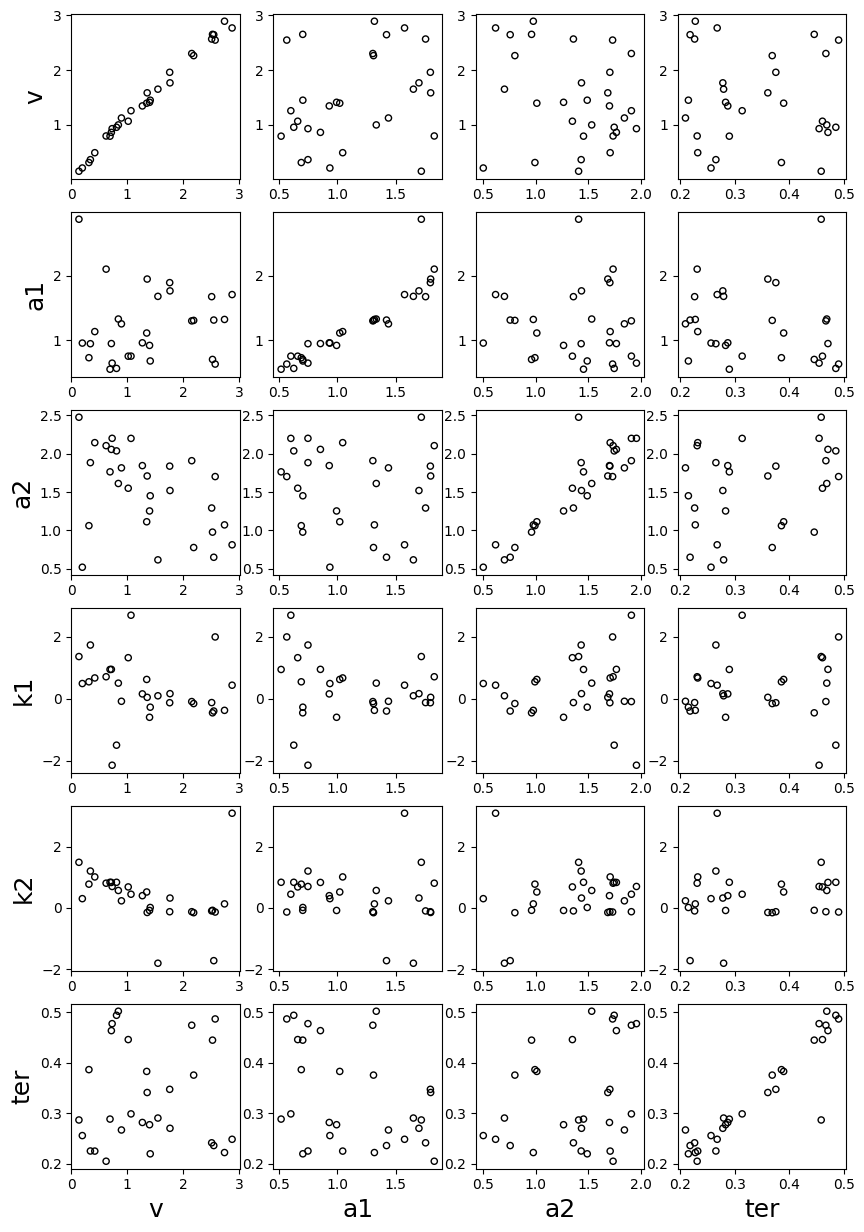

In [53]:
param_DDM_label = ["v", "a1","a2","ter"]
param_OUM_label = ["v", "a1","a2","k1","k2","ter"]
sim_fit_plot_all(param_DDM, param_OUM, param_DDM_label, param_OUM_label,s = 20, figsize=(10,15))

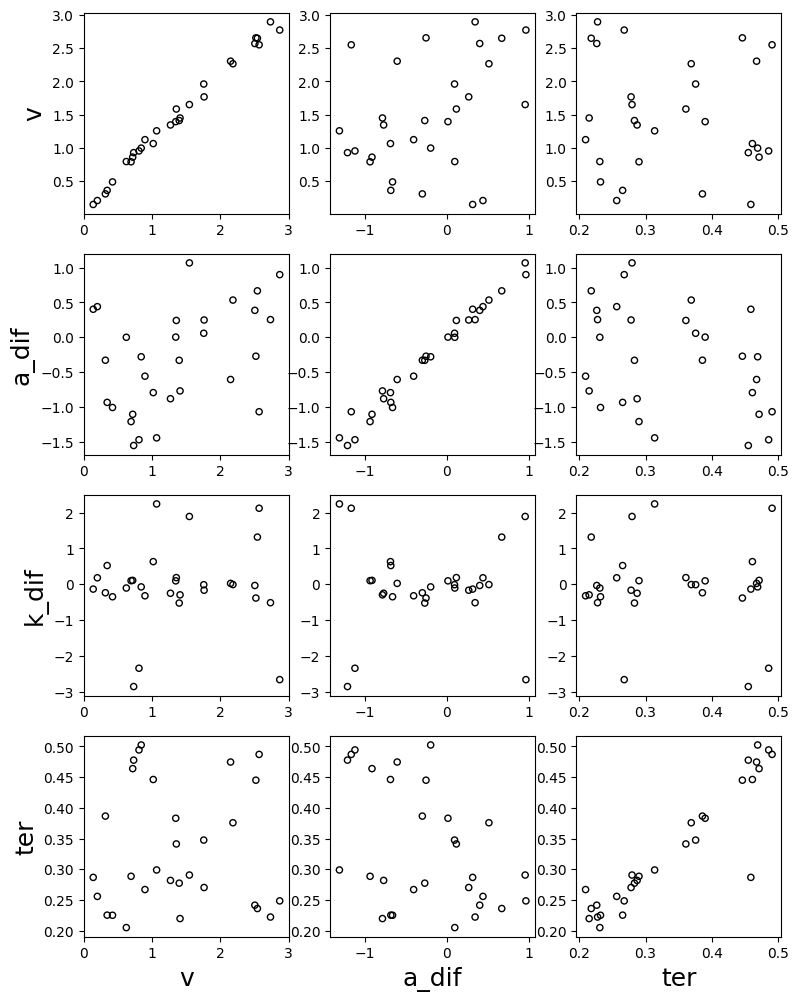

In [54]:
param_DDM_dif_label = ["v", "a_dif","ter"]
param_OUM_dif_label = ["v", "a_dif","k_dif","ter"]
sim_fit_plot_all(param_DDM_dif, param_OUM_dif, param_DDM_dif_label, param_OUM_dif_label,s = 20, figsize=(9,12))

## Simulate with OUM with two boundary and two inhibition parameters
## Fit with OUM allowing both boundary and inhibition to vary

In [65]:
##                              v  a1 a2  k1 k2 ter 
prior = utils.BoxUniform(low  =[0,0.5,0.5, 0,0, 0.2], 
                         high =[3,  2,  2,8,8,0.5])

n_sim = 30
param = np.array(prior.sample((n_sim,)))


In [67]:
df_all = pd.DataFrame(columns = ['v','a1','a2', 'k1', 'k2', 'ter'])

for i in range(n_sim):
    print(i)
    model = Model(name='Simple model (fitted)',
                  drift=DriftSpeedAcc(drift=param[i,0],
                                      Kspeed=param[i,3],
                                      Kacc=param[i,4]),
                  noise=NoiseConstant(noise =1),
                  bound=BoundSpeedAcc(Bspeed = param[i,1],Bacc = param[i,2]),
                  overlay=OverlayNonDecision(nondectime=param[i,5]),
                  dx=.001, dt=.001, T_dur=3)

    samp1 = model.solve({"SAT": 1}).resample(1000)
    samp2 = model.solve({"SAT": 2}).resample(1000)
    df = samp1.to_pandas_dataframe(drop_undecided = "True").append(samp2.to_pandas_dataframe(drop_undecided = "True"))
    DDM_sample = Sample.from_pandas_dataframe(df, rt_column_name="RT", correct_column_name="correct")

    model_fit = Model(name='Simple model (fitted)',
                  drift=DriftSpeedAcc(drift = Fittable(minval=0, maxval=4),
                                      Kspeed=Fittable(minval=-5, maxval=10),
                                      Kacc=Fittable(minval=-5, maxval=10)),

                  noise=NoiseConstant(noise=1),
                  bound=BoundSpeedAcc(
                      Bspeed=Fittable(minval=.3, maxval=3),
                      Bacc=Fittable(minval=.3, maxval=3)),
                  overlay=OverlayNonDecision(nondectime=Fittable(minval=0, maxval=1)),
                  dx=.001, dt=.001, T_dur=3)

    fit_adjust_model(DDM_sample, model_fit,
                     fitting_method="differential_evolution",
                     lossfunction=LossRobustBIC, verbose=False)


    df_sim = pd.DataFrame({
                           'v': np.array(model_fit.parameters()['drift']['drift']), 
                           'a1': np.array(model_fit.parameters()['bound']['Bspeed']),
                           'a2': np.array(model_fit.parameters()['bound']['Bacc']),
                           'k1': np.array(model_fit.parameters()['drift']['Kspeed']),
                           'k2': np.array(model_fit.parameters()['drift']['Kacc']),
                           'ter': np.array(model_fit.parameters()['overlay']['nondectime'])
                          }, index=[i])
    df_all = df_all.append(df_sim)
    df_all.to_csv("OUM-OUM-SAT-fitting")

0


Info: Params [2.4776988  3.14653599 6.93956828 1.49148553 0.60490703 0.37873539] gave -2272.843406032326


1


Info: Params [0.70335411 0.75155356 3.48337885 0.7048539  0.62865839 0.48553413] gave 1387.3616463345095


2


Info: Params [2.38530109 4.47573129 5.51656865 0.56799697 1.67823919 0.34570716] gave -2240.0744355991005


3


Info: Params [2.75619545 6.98668527 2.84508078 0.71160257 1.84023215 0.32529989] gave -2581.9336722436365


4


Info: Params [1.2523355  2.02435351 0.97213702 1.87200339 1.83678867 0.24362671] gave 2949.4959785385686


5


Info: Params [2.76379521 7.87130123 0.46765635 0.90779609 0.90471408 0.26998926] gave -2535.464840718582


6


Info: Params [1.69620629 3.48961174 4.61605546 1.0316686  0.97513647 0.43385871] gave -304.5290647956568


7


Info: Params [0.33808469 0.81597217 4.74012627 1.18970205 0.56287427 0.25352401] gave 2548.6002912953245


8


Info: Params [1.48226952 7.20533006 0.38738124 1.48768161 0.87268016 0.23763946] gave 295.9108650244172


9


Info: Params [0.6098959  2.91323379 7.77801254 1.11531946 1.99245668 0.41809998] gave 1300.2765497935964


10


Info: Params [2.18556578 4.19571366 2.34034935 1.16544304 0.57572109 0.25912817] gave -1635.6824724771927


11


Info: Params [1.21278833 4.89120364 1.48155115 1.94833235 1.85153494 0.40690476] gave 1882.7477190891173


12


Info: Params [2.13800066 6.96830029 1.32386341 2.17242562 1.32923721 0.25458943] gave -851.9256871232574


13


Info: Params [2.29466217 3.52418706 0.94785061 0.99906225 1.5388974  0.27060958] gave -654.7819745980746


14


Info: Params [0.10483635 2.36651724 5.20888454 1.45095189 0.75157338 0.34178082] gave 2419.0049109225556


15


Info: Params [1.30856336 0.97790282 5.59572526 1.04721845 1.91577968 0.47988707] gave 1187.8878561951706


16


Info: Params [3.11267861 4.67792063 3.21972258 0.81022991 1.26880399 0.45336195] gave -3053.4296078969687


17


Info: Params [1.36769285 2.62534879 2.76900391 1.78848885 0.47060583 0.2821323 ] gave 64.56307441528342


18


Info: Params [2.49306209 6.67493084 0.42133641 1.57713728 1.09742406 0.35887893] gave -1450.1442194193846


19


Info: Params [2.01099482 5.4573915  0.65960085 1.64267801 1.688693   0.48013686] gave 33.09155638604485


20


Info: Params [1.32481557 0.32089409 4.47692109 1.71595466 1.6384972  0.34631925] gave 2014.558392991558


21


Info: Params [2.2606365  1.25438409 2.13638255 1.09967104 1.49476301 0.34055317] gave -568.165462671787


22


Info: Params [2.45915624 0.70413118 3.14377252 1.30528021 1.3820734  0.5294506 ] gave -849.8052333830504


23


Info: Params [1.75761604 2.19450238 4.86587628 1.90323405 0.91678567 0.2847106 ] gave 34.97723068332313


24


Info: Params [1.24535953 3.0305856  1.27753403 2.00114646 1.16562227 0.39458105] gave 2107.2235708352946


25


Info: Params [2.90505625 4.32750864 6.3992668  1.18835719 1.41907054 0.40594889] gave -2796.053470631946


26


Info: Params [0.2461612  1.08687908 2.24134033 1.76411015 1.2048099  0.26815824] gave 4592.098828424018


27


Info: Params [0.32682615 2.95549812 5.30206633 1.44721275 2.45544458 0.42372529] gave 2376.7835164611024


28


Info: Params [0.05133073 5.64704097 6.67479583 1.52215996 0.99466124 0.38321678] gave 770.5948546050492


29


Info: Params [0.49659438 4.77039761 5.36678681 0.84354462 2.09947673 0.33235879] gave 1113.4232707241774


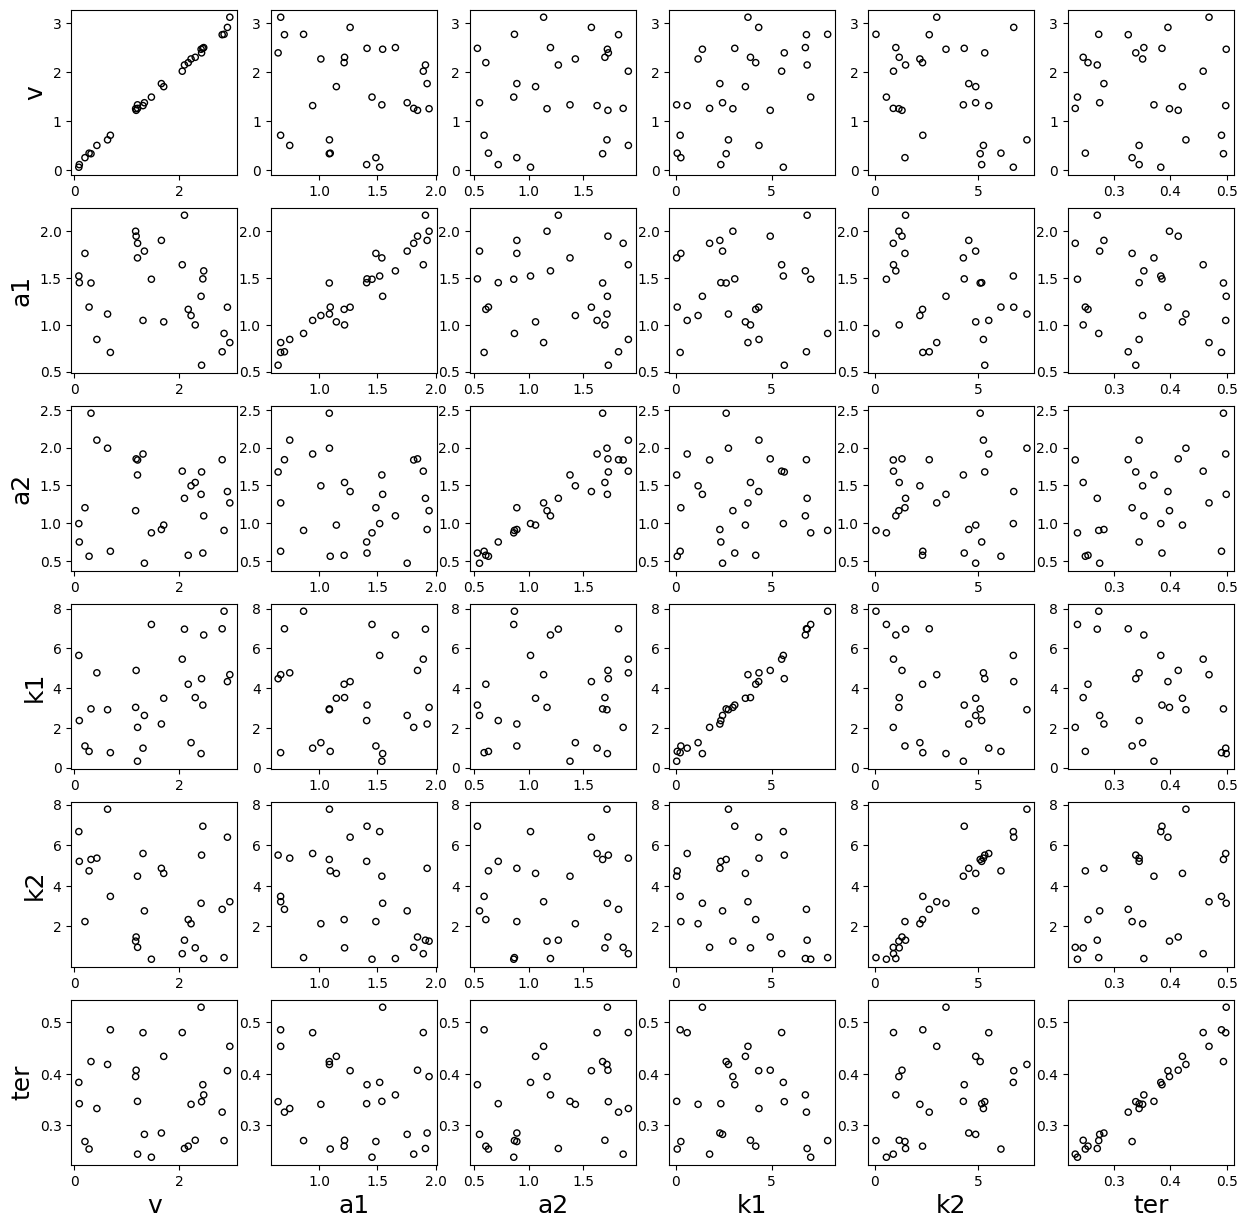

In [101]:
df_all = pd.read_csv("OUM-OUM-SAT-fitting")
sim_fit_plot_all(param, np.array(df_all)[:,2:], param_DDM_label, param_OUM_label,s = 20, figsize=(15,15))


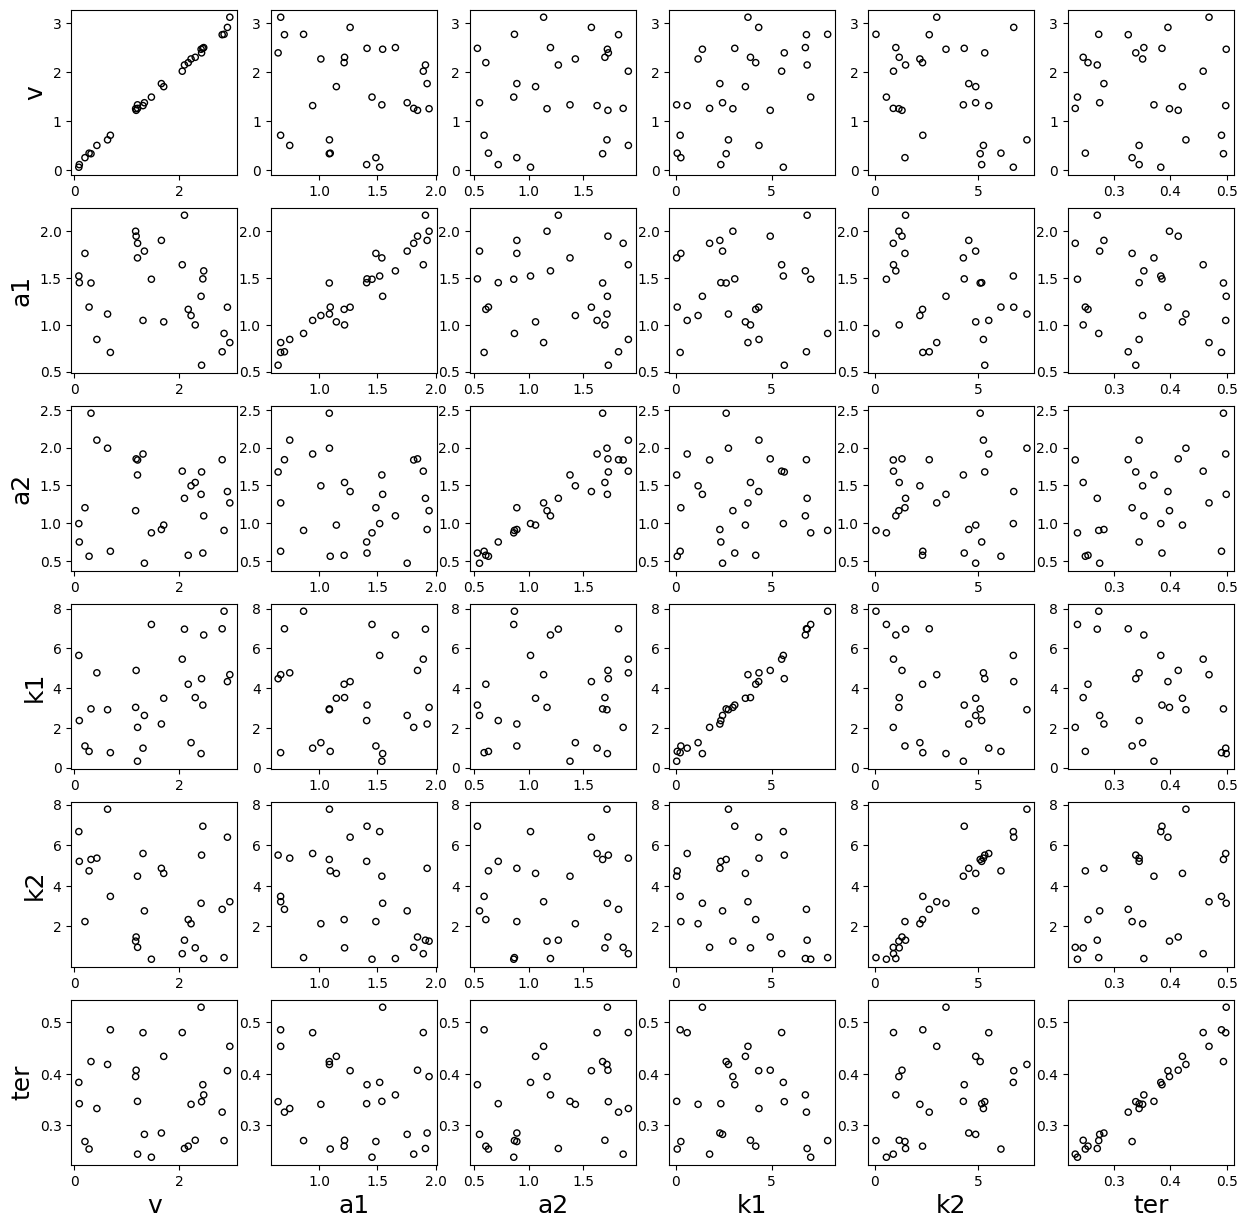

In [77]:
param_DDM_label = ["v", "a1","a2","k1","k2","ter"]
param_OUM_label = ["v", "a1","a2","k1","k2","ter"]
sim_fit_plot_all(param, np.array(df_all)[:,1:], param_DDM_label, param_OUM_label,s = 20, figsize=(15,15))


In [79]:
param_OUM_sim_df = pd.DataFrame(param, columns = ["v", "a1","a2","k1","k2","ter"])



In [104]:
param_OUM_sim_df = pd.read_csv("OUM-OUM-SAT-simulation")
param_OUM_sim_df["a_dif"] = param_OUM_sim_df["a1"] - param_OUM_sim_df["a2"]
param_OUM_sim_df["k_dif"] = param_OUM_sim_df["k1"] - param_OUM_sim_df["k2"]
param_OUM_sim_df = np.array(param_OUM_sim_df[["v", "a_dif", "k_dif", "ter"]])


In [105]:
param_OUM_fit_df = pd.read_csv("OUM-OUM-SAT-fitting")


param_OUM_fit_df["a_dif"] = param_OUM_fit_df["a1"] - param_OUM_fit_df["a2"]
param_OUM_fit_df["k_dif"] = param_OUM_fit_df["k1"] - param_OUM_fit_df["k2"]


param_OUM_fit_df = np.array(param_OUM_fit_df[["v", "a_dif", "k_dif", "ter"]])


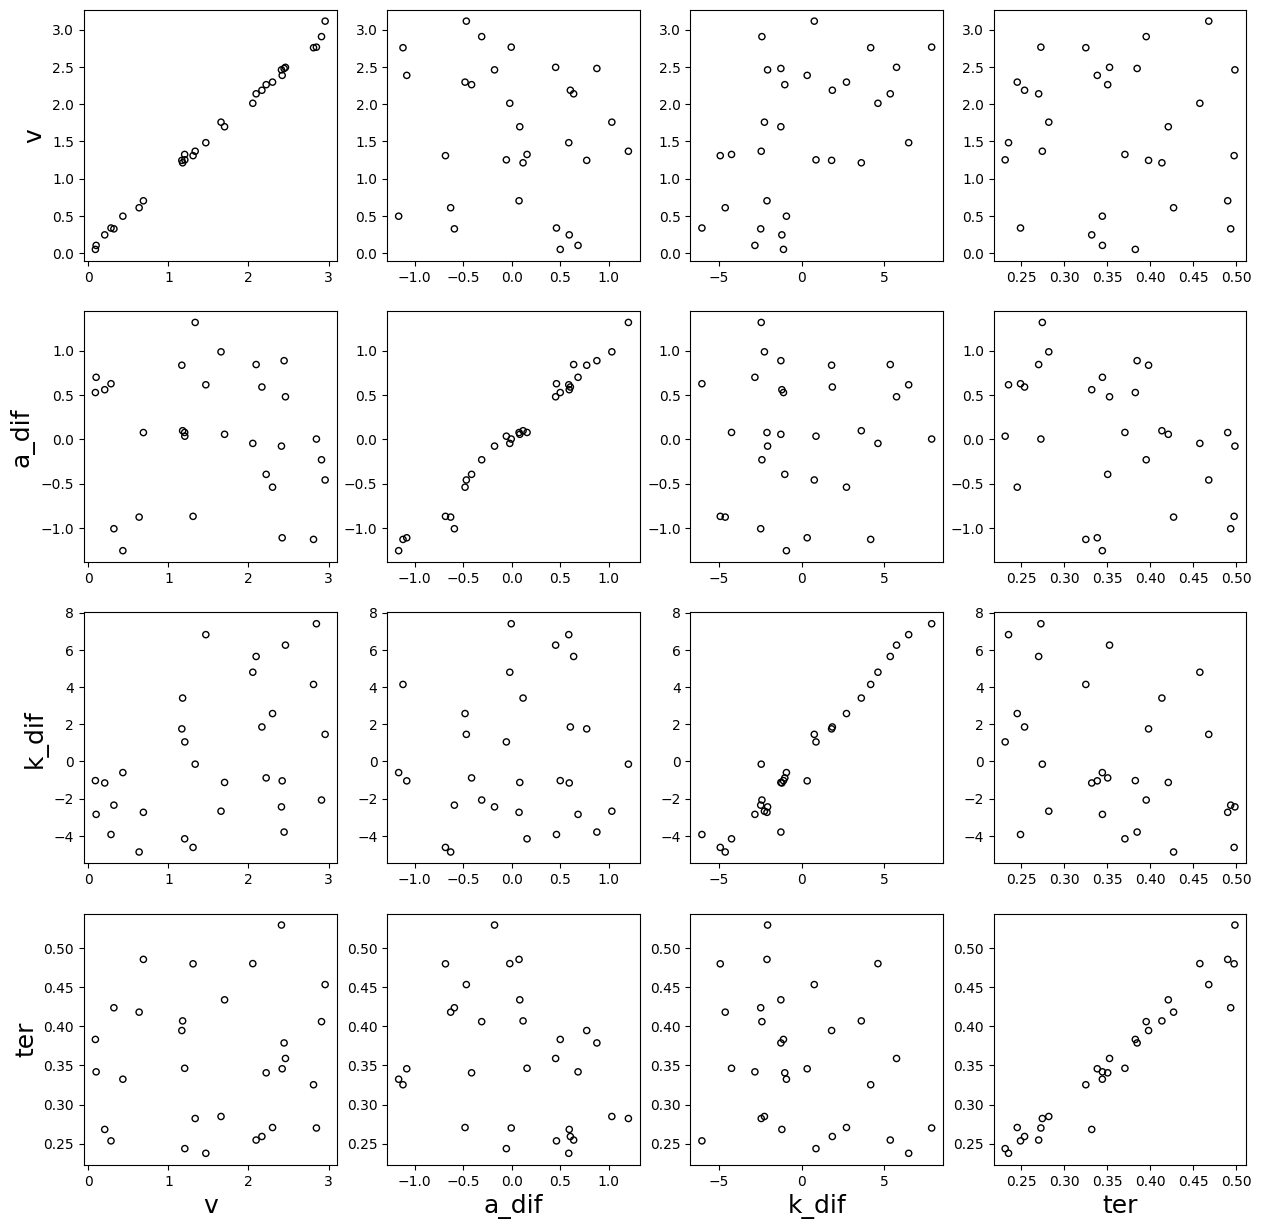

In [106]:
param_OUM_label_sim = ["v", "a_dif","k_dif","ter"]
param_OUM_label_fit = ["v", "a_dif","k_dif","ter"]
sim_fit_plot_all(param_OUM_sim_df, param_OUM_fit_df, param_OUM_label_sim, param_OUM_label_fit,s = 20, figsize=(15,15))
